# Method: RC 
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import sparse

import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax.numpy import tanh
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. RC Implementation

In [9]:
def get_parameters(nn_size, connectivity, spec_radius, lambd, 
                   seed, batch_size, num_epoch, lr_schedule = [1e-4], 
                   early_stopping = EARLY_STOPPING):
    """
    Returns trained parameters (beta, intercept) and hidden layer values
    """
    def initialize_coef():
        """
        Initializes W_in and W. 
        W_in size = nn_size x data_dim
        W size = nn_size x nn_size
        """
        start = time()

        # Generate input -> hidden unit weights
        W_in = 2 * (np.random.rand(nn_size, data_dim) - 0.5) 
        W_in = W_in / (4 * np.sqrt(data_dim))

        # Generate hidden -> hidden unit weights
        # Considers connectivity to make the matrix sparse
        start_mat = time()
        rows = np.concatenate([np.full(connectivity, i) for i in range(nn_size)])
        cols = np.concatenate([np.random.choice(range(nn_size), size = connectivity, replace = False) for _ in range(nn_size)])
        vals = np.random.uniform(low = -omega, high = omega, size = (nn_size * connectivity))
        W = sparse.csr_matrix((vals, (rows, cols)), shape = (nn_size, nn_size))
        end_mat = time()
        print(f"W generated. Time taken: {end_mat - start_mat:.2f}s")

        # Calculate eigenvalues for scaling of matrix
        print("Calculating eigenvalue")
        e_start = time()
        eigenvals = sparse.linalg.eigs(W, which = "LM", return_eigenvectors = False, k = 1)
        max_eigen = np.abs(eigenvals)
        e_end = time()
        print(f"Eigenvalue calculated. Time taken: {e_end - e_start:.2f}s")

        # Scale matrix by spectral radius
        W = W / max_eigen * spec_radius # scale the matrix W by its spectral radius
        W = sparse.csr_matrix(W)
        
        end = time()
        print(f"W and W_in generated. Time taken: {end-start:.2f}s")
        print()
        
        return W_in, W
    
    def generate_hidden_states(W_in, W):
        """ 
        Generate hidden states (z) values
        hidden_states size = data_size x nn_size 
        """
        start = time()
        
        print("Generating z values...")
        indiv_z = np.zeros(shape = nn_size)
        hidden_states = np.zeros((train_size, nn_size))
        
        for t in range(train_size):  
            indiv_z = (1 - alpha) * indiv_z + \
                alpha * np.tanh(W_in @ x[t] + W @ indiv_z)
            hidden_states[t, :] = indiv_z
        end = time()
        print(f"z values generated. Time taken: {end-start:.2f}s")
        
        return hidden_states
    
    def mse(y, y_pred):
        return jnp.mean((y_pred - y)**2)
    
    @jax.jit
    def mse_loss(params, x, y):
        """
        returns mean squared error
        """
        beta, intercept = params
        pred = x @ beta + intercept
        return mse(pred, y) + np.mean(beta**2) * lambd / 2 + np.mean(intercept**2) * lambd / 2
    
    def validation_loss(params, x_val, y_val):
        beta, intercept = params
        num_data_test, trans, data_dim = x_val.shape # testing ex, # steps used (transient), dim of data

        def prediction(inp):
            """
            Returns the mean of one of the testing input

            mean will be a length_to_test x data_dim vector
            """
            z = np.zeros((nn_size // 2, ))
            for i in range(trans):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)

            mus = []
            stddevs = []

            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
            mus.append(x)

            for _ in range(L_forecast_test - 1):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
                x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
                mus.append(x)

            return mus

        mean_list = []
        sd_list = []

        for i in range(num_data_test):
            pred = prediction(x_val[i])
            mean_list.append(pred)

        return mse(mean_list, y_val)

    def training(x, y):
        """ 
        Trains regression of y~x using SGD. 
        Returns parameters (beta, intercept) where 
        beta, intercept -> weights to determine the mean
        
        beta size = nn_size x data_dim
        intercept = data_dim (will be added for each training data)
        
        should predict a mu with train_size x data_dim (\mu per dimension per datapoint)
        and a sigma with train_size x 1 (single \sigma for all dimensions per datapoint)
        """
        
        @jax.jit
        def step(opt_state, x, y):
            params = get_params(opt_state)
            value, g = value_and_grad(mse_loss)(params, x, y)
            opt_state = opt_update(0, g, opt_state)
            return get_params(opt_state), opt_state, value

        start = time()
        
        # Plot loss
        loss_train_traj = []
        loss_train_all_traj = []
        
        # Init parameters
        beta = np.random.normal(0, 1 / np.sqrt(nn_size), size = (nn_size, data_dim))
        intercept = np.random.normal(0, 1 / np.sqrt(nn_size * 2), size = (data_dim, ))
        
        t_size = int(1. * train_size)
        
        overall_best_mse = 9999999
        
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init([beta, intercept])
            
            # For early stopping
            best_state = opt_state
            counter = 0 
            best_val_loss = 9999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                T_indices = np.arange(train_size)
                np.random.shuffle(T_indices)

                loss_epoch_train = []
                for k in range(t_size // batch_size + 1):
                    t_start = T_indices[np.arange(k * batch_size, (k+1) * batch_size).astype(int) % len(T_indices)]
                    x_batch = x[t_start]
                    y_batch = y[t_start]

                    params, opt_state, l = step(opt_state, x_batch, y_batch)
                    loss_epoch_train.append(l)
                
                
                loss_train_all_traj += loss_epoch_train
                mse_train = np.mean(loss_epoch_train)
                loss_train_traj.append(mse_train)
                
                e_end = time()
                
                if mse_train < best_val_loss:
                    best_val_loss = mse_train
                    counter = 0
                    best_state = opt_state
                else:
                    counter += 1
                    
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch > 49):
                    print(f"Epoch {epoch + 1}: Train time = {e_end - e_start:.2f} | Train Loss = {mse_train:.7f}", end = " ")
                    print()
                if counter == early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f}")
                    break
            
            print(f"Best Training MSE: {best_val_loss:.7f}") 
            
            if best_val_loss < overall_best_mse:
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_val_loss
                overall_best_state = best_state
            
            beta, intercept = get_params(overall_best_state)
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return get_params(overall_best_state) # beta, intercept
    
    start = time()
   
    x, y = train.data[:-1], train.data[1:]
    copy_x, copy_y = x, y 
    train_size, data_dim = x.data.shape
       
    np.random.seed(seed)
    W_in, W = initialize_coef()
    z = generate_hidden_states(W_in, W)

    # Want to regression Y ~ X ==> Y ~ [z, z**2]
    final_y = y[transient:]
    final_z = z[transient:]
    print("Concatenating z with z**2", end = " "); concat_start = time()
    final_z = np.concatenate([final_z, final_z**2], axis = 1) # shape: train_size x (nn_size*2)
    concat_end = time()
    print(f"Contenation complete. Time taken: {concat_end-concat_start:.2f}s", end = "\n\n")
    
    train_size, nn_size = final_z.shape
    
    params = training(final_z, final_y)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return params, (final_z, W_in, W)

In [10]:
def get_test_pred(data_test, nn_size, params, W_in, W):   
    beta, intercept = params
    num_data_test, trans, data_dim = data_test.shape # testing ex, # steps used (transient), dim of data
    
    def prediction(inp):
        """
        Returns the mean of one of the testing input
        
        mean will be a length_to_test x data_dim vector
        """
        
        z = np.zeros((nn_size, ))
        for i in range(trans):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)
        
        mus = []
        stddevs = []
        
        x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
        mus.append(x)
        
        for _ in range(L_forecast_test - 1):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
            mus.append(x)
        
        return mus
    
    start = time()
    
    mean_list = []
    sd_list = []
    
    for i in range(num_data_test):
        pred = prediction(data_test[i])
        mean_list.append(pred)

        if (i+1) % 10 == 0:
            print(f"{(i+1) / num_data_test * 100:.2f}% done")
    
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mean_list)

# 3. Parameter tuning

There are 4 parameters to tune
- nn_size [3000, 6000, 9000, 12000, 150000] - size of the hidden layer
- connectivity [4, 8] - sparseness of W
- spec_radius [0.1, 0.3, 0.5, 0.7] - spectral radius (scale) of W
- lambda [1e-2, 1e-4, 1e-6] - ridge regression penalty

Through initial expeirments, it was shown that the value of lambda does not greatly affect the results. As a full grid search will be computationally expensive, nn_size is first tuned. Then, a lambda value is chosen, followed by the spectral radius and lastly, the optimal connectivity.

## 3.1 nn_size

**Parameters**
- nn_size = [3000, 6000, 9000, 12000, 15000]
- connectivity = 4
- spec_radius = 0.5 
- lambda = 1e-4

In [11]:
ridge_penalty = 1e-4
connectivity = 4
spec_radius = 0.5
transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

### 3.1.1 nn_size = 3000

In [36]:
nn_size = 3000
lr_list = [1e-3]
epoch_list = [400]

In [37]:
# Testing with validation
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 1.39s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 0.22s
W and W_in generated. Time taken: 1.92s

Generating z values...
z values generated. Time taken: 13.41s
Concatenating z with z**2 Contenation complete. Time taken: 2.76s

Epoch 10: Train time = 2.10 | Train Loss = 0.0000389 
Epoch 20: Train time = 2.12 | Train Loss = 0.0000405 
Epoch 30: Train time = 2.13 | Train Loss = 0.0000337 
Epoch 40: Train time = 2.15 | Train Loss = 0.0000297 
Epoch 50: Train time = 2.10 | Train Loss = 0.0000280 
Epoch 51: Train time = 2.15 | Train Loss = 0.0000269 
Epoch 52: Train time = 2.13 | Train Loss = 0.0000267 
Epoch 53: Train time = 2.13 | Train Loss = 0.0000265 
Epoch 54: Train time = 2.25 | Train Loss = 0.0000264 
Epoch 56: Train time = 2.13 | Train Loss = 0.0000259 
Epoch 58: Train time = 2.11 | Train Loss = 0.0000256 
Epoch 60: Train time = 2.14 | Train Loss = 0.0000263 
Epoch 62: Train time = 2.10 | Train Loss = 0.0000249 
Epoch 65: Train time = 1.93 | Tra

In [38]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 72.71


In [39]:
save_obj(mean_pred, "results/rc", "3_1_1_mu_preds.pkl")

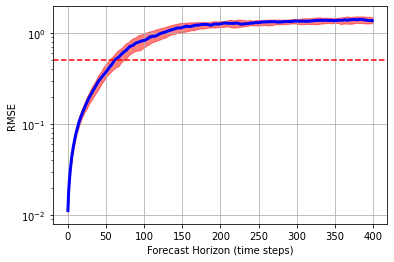

It takes around t = 0.62 for mean error to exceed 0.5


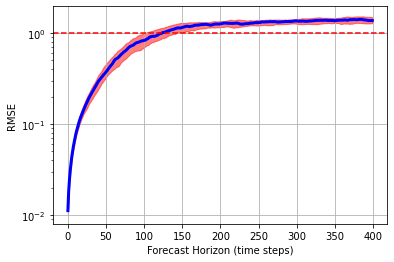

It takes around t = 1.24 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.140
Median NRMSE at t = 0.5: 0.374
Median NRMSE at t = 1: 0.826
Median NRMSE at t = 2: 1.256
Median NRMSE at t = 3: 1.349


In [40]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 6000

In [41]:
nn_size = 6000
lr_list = [5e-4]
epoch_list = [400]

In [42]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list,
                                 early_stopping = 5)

W generated. Time taken: 4.98s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 1.07s
W and W_in generated. Time taken: 7.04s

Generating z values...
z values generated. Time taken: 23.46s
Concatenating z with z**2 Contenation complete. Time taken: 5.84s

Epoch 10: Train time = 4.49 | Train Loss = 0.0000331 
Epoch 20: Train time = 4.54 | Train Loss = 0.0000351 
Epoch 30: Train time = 4.44 | Train Loss = 0.0000291 
Epoch 40: Train time = 4.53 | Train Loss = 0.0000257 
Epoch 50: Train time = 4.53 | Train Loss = 0.0000222 
Epoch 51: Train time = 4.51 | Train Loss = 0.0000222 
Epoch 53: Train time = 4.51 | Train Loss = 0.0000217 
Epoch 54: Train time = 4.47 | Train Loss = 0.0000217 
Epoch 56: Train time = 4.52 | Train Loss = 0.0000217 
Epoch 58: Train time = 4.49 | Train Loss = 0.0000205 
Epoch 60: Train time = 4.48 | Train Loss = 0.0000212 
Epoch 61: Train time = 4.45 | Train Loss = 0.0000204 
Epoch 63: Train time = 4.44 | Train Loss = 0.0000200 
Epoch 66: Train time = 4.54 | Tra

In [43]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 108.28


In [44]:
save_obj(mean_pred, "results/rc", "3_1_2_mu_preds.pkl")

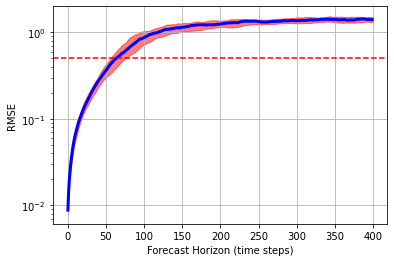

It takes around t = 0.64 for mean error to exceed 0.5


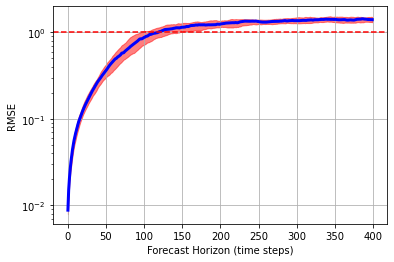

It takes around t = 1.19 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.127
Median NRMSE at t = 0.5: 0.364
Median NRMSE at t = 1: 0.874
Median NRMSE at t = 2: 1.246
Median NRMSE at t = 3: 1.364


In [45]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 9000

In [56]:
nn_size = 9000
lr_list = [3e-4]
epoch_list = [400]

In [57]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 12.35s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 10.50s
W and W_in generated. Time taken: 24.78s

Generating z values...
z values generated. Time taken: 37.88s
Concatenating z with z**2 Contenation complete. Time taken: 9.41s

Epoch 10: Train time = 7.68 | Train Loss = 0.0000299 
Epoch 20: Train time = 7.72 | Train Loss = 0.0000315 
Epoch 30: Train time = 7.89 | Train Loss = 0.0000259 
Epoch 40: Train time = 7.70 | Train Loss = 0.0000219 
Epoch 50: Train time = 8.03 | Train Loss = 0.0000191 
Epoch 52: Train time = 7.68 | Train Loss = 0.0000186 
Epoch 54: Train time = 7.72 | Train Loss = 0.0000182 
Epoch 56: Train time = 7.64 | Train Loss = 0.0000177 
Epoch 59: Train time = 7.64 | Train Loss = 0.0000173 
Epoch 60: Train time = 7.55 | Train Loss = 0.0000170 
Epoch 63: Train time = 7.67 | Train Loss = 0.0000168 
Epoch 66: Train time = 7.68 | Train Loss = 0.0000165 
Epoch 67: Train time = 7.63 | Train Loss = 0.0000163 
Epoch 70: Train time = 7.51 | 

In [58]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 175.49


In [59]:
save_obj(mean_pred, "results/rc", "3_1_3_mu_preds.pkl")

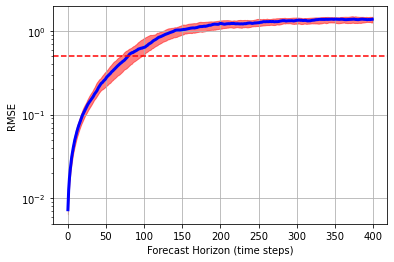

It takes around t = 0.79 for mean error to exceed 0.5


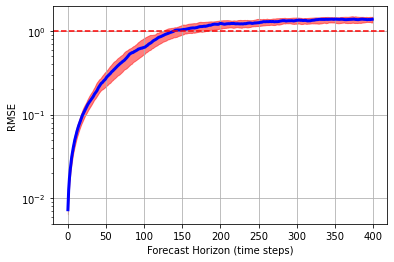

It takes around t = 1.40 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.102
Median NRMSE at t = 0.5: 0.273
Median NRMSE at t = 1: 0.637
Median NRMSE at t = 2: 1.229
Median NRMSE at t = 3: 1.339


In [60]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 12000

In [30]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]

In [31]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 23.27s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.55s
W and W_in generated. Time taken: 28.86s

Generating z values...
z values generated. Time taken: 45.79s
Concatenating z with z**2 Contenation complete. Time taken: 10.93s

Epoch 10: Train time = 10.08 | Train Loss = 0.0000252 
Epoch 20: Train time = 10.25 | Train Loss = 0.0000237 
Epoch 30: Train time = 9.31 | Train Loss = 0.0000191 
Epoch 40: Train time = 9.84 | Train Loss = 0.0000155 
Epoch 50: Train time = 9.82 | Train Loss = 0.0000130 
Epoch 51: Train time = 9.90 | Train Loss = 0.0000127 
Epoch 53: Train time = 9.96 | Train Loss = 0.0000124 
Epoch 54: Train time = 9.83 | Train Loss = 0.0000122 
Epoch 55: Train time = 9.86 | Train Loss = 0.0000119 
Epoch 56: Train time = 9.85 | Train Loss = 0.0000119 
Epoch 57: Train time = 9.84 | Train Loss = 0.0000117 
Epoch 58: Train time = 9.80 | Train Loss = 0.0000115 
Epoch 59: Train time = 9.83 | Train Loss = 0.0000113 
Epoch 60: Train time = 9.81 

In [32]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 167.72


In [35]:
save_obj(mean_pred, "results/rc", "3_1_4_mu_preds.pkl")

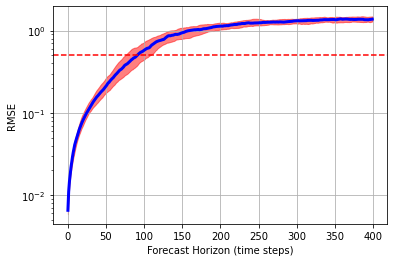

It takes around t = 0.91 for mean error to exceed 0.5


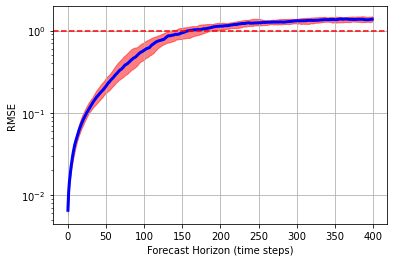

It takes around t = 1.59 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.082
Median NRMSE at t = 0.5: 0.212
Median NRMSE at t = 1: 0.578
Median NRMSE at t = 2: 1.136
Median NRMSE at t = 3: 1.320


In [34]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.5 nn_size = 15000

In [61]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]

In [62]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 31.23s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 7.24s
W and W_in generated. Time taken: 43.50s

Generating z values...
z values generated. Time taken: 59.48s
Concatenating z with z**2 Contenation complete. Time taken: 135.49s

Epoch 10: Train time = 20.09 | Train Loss = 0.0000244 
Epoch 20: Train time = 21.29 | Train Loss = 0.0000243 
Epoch 30: Train time = 20.44 | Train Loss = 0.0000192 
Epoch 40: Train time = 20.29 | Train Loss = 0.0000156 
Epoch 50: Train time = 19.22 | Train Loss = 0.0000131 
Epoch 51: Train time = 18.90 | Train Loss = 0.0000128 
Epoch 52: Train time = 18.04 | Train Loss = 0.0000127 
Epoch 53: Train time = 17.06 | Train Loss = 0.0000124 
Epoch 54: Train time = 18.19 | Train Loss = 0.0000123 
Epoch 55: Train time = 17.71 | Train Loss = 0.0000121 
Epoch 56: Train time = 17.89 | Train Loss = 0.0000120 
Epoch 57: Train time = 17.86 | Train Loss = 0.0000117 
Epoch 59: Train time = 17.56 | Train Loss = 0.0000114 
Epoch 60: Train 

In [63]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 224.31


In [64]:
save_obj(mean_pred, "results/rc", "3_1_5_mu_preds.pkl")

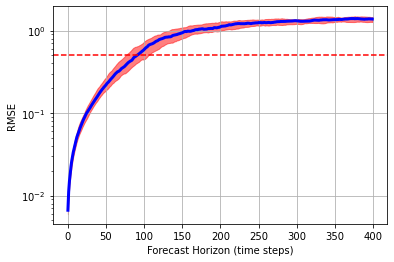

It takes around t = 0.91 for mean error to exceed 0.5


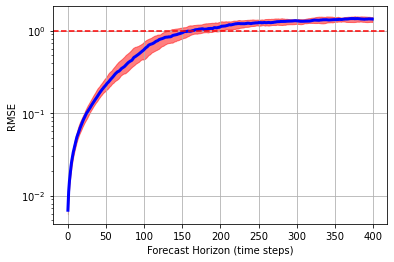

It takes around t = 1.64 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.082
Median NRMSE at t = 0.5: 0.220
Median NRMSE at t = 1: 0.591
Median NRMSE at t = 2: 1.112
Median NRMSE at t = 3: 1.313


In [65]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 lambda (ridge penalty)

**Parameters**
- nn_size = 12000
- connectivity = 4
- spec_radius = 0.5
- lambda = [1e-2, 1e-4, 1e-6]

In [12]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]

### 3.2.1 lambda = 1e-2

In [16]:
ridge_penalty = 1e-2

In [17]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 22.19s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 1.39s
W and W_in generated. Time taken: 26.75s

Generating z values...
z values generated. Time taken: 51.22s
Concatenating z with z**2 Contenation complete. Time taken: 13.01s

Epoch 10: Train time = 13.17 | Train Loss = 0.0000257 
Epoch 20: Train time = 14.03 | Train Loss = 0.0000245 
Epoch 30: Train time = 13.58 | Train Loss = 0.0000198 
Epoch 40: Train time = 13.19 | Train Loss = 0.0000161 
Epoch 50: Train time = 13.43 | Train Loss = 0.0000135 
Epoch 51: Train time = 13.19 | Train Loss = 0.0000132 
Epoch 52: Train time = 13.06 | Train Loss = 0.0000132 
Epoch 53: Train time = 12.83 | Train Loss = 0.0000129 
Epoch 54: Train time = 12.61 | Train Loss = 0.0000127 
Epoch 55: Train time = 13.04 | Train Loss = 0.0000124 
Epoch 56: Train time = 13.12 | Train Loss = 0.0000124 
Epoch 57: Train time = 13.07 | Train Loss = 0.0000122 
Epoch 58: Train time = 13.05 | Train Loss = 0.0000120 
Epoch 59: Train t

In [18]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 201.01


In [19]:
save_obj(mean_pred, "results/rc", "3_2_1_mu_preds.pkl")

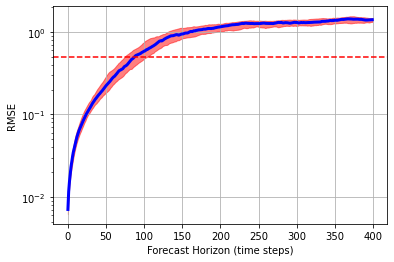

It takes around t = 0.88 for mean error to exceed 0.5


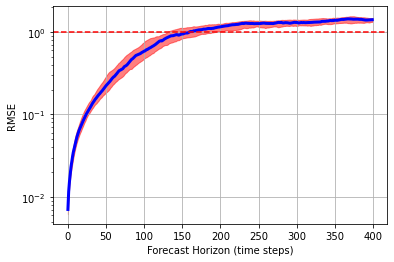

It takes around t = 1.60 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.084
Median NRMSE at t = 0.5: 0.223
Median NRMSE at t = 1: 0.584
Median NRMSE at t = 2: 1.150
Median NRMSE at t = 3: 1.299


In [20]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 lambda = 1e-4
Already done is 3.1.4

### 3.2.3 lambda = 1e-6

In [21]:
ridge_penalty = 1e-6

In [22]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 21.89s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 4.59s
W and W_in generated. Time taken: 29.60s

Generating z values...
z values generated. Time taken: 56.68s
Concatenating z with z**2 Contenation complete. Time taken: 1053.34s

Epoch 10: Train time = 10.41 | Train Loss = 0.0000254 
Epoch 20: Train time = 10.38 | Train Loss = 0.0000239 
Epoch 30: Train time = 10.33 | Train Loss = 0.0000192 
Epoch 40: Train time = 10.34 | Train Loss = 0.0000156 
Epoch 50: Train time = 10.38 | Train Loss = 0.0000130 
Epoch 51: Train time = 10.29 | Train Loss = 0.0000127 
Epoch 53: Train time = 10.52 | Train Loss = 0.0000124 
Epoch 54: Train time = 10.43 | Train Loss = 0.0000122 
Epoch 55: Train time = 10.41 | Train Loss = 0.0000119 
Epoch 56: Train time = 10.64 | Train Loss = 0.0000119 
Epoch 57: Train time = 10.40 | Train Loss = 0.0000117 
Epoch 58: Train time = 10.42 | Train Loss = 0.0000115 
Epoch 59: Train time = 10.51 | Train Loss = 0.0000113 
Epoch 60: Train

In [23]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 220.29


In [24]:
save_obj(mean_pred, "results/rc", "3_2_3_mu_preds.pkl")

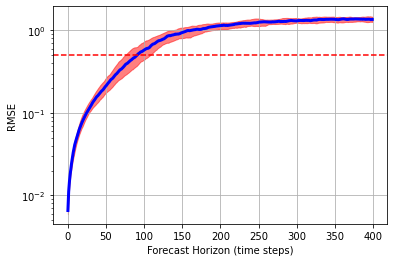

It takes around t = 0.91 for mean error to exceed 0.5


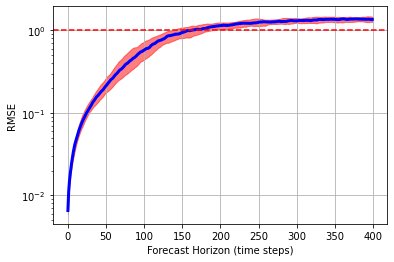

It takes around t = 1.61 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.082
Median NRMSE at t = 0.5: 0.213
Median NRMSE at t = 1: 0.582
Median NRMSE at t = 2: 1.148
Median NRMSE at t = 3: 1.307


In [25]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.3 spec_radius

**Parameters**
- nn_size = 12000
- connectivity = 4
- spec_radius = [0.1, 0.3, 0.5, 0.7]
- lambda = 1e-6

In [13]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]
ridge_penalty = 1e-6

### 3.3.1 spec_radius = 0.1

In [14]:
spec_radius = 0.1

In [15]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 25.56s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 1.65s
W and W_in generated. Time taken: 30.26s

Generating z values...
z values generated. Time taken: 51.31s
Concatenating z with z**2 Contenation complete. Time taken: 11.86s

Epoch 10: Train time = 10.29 | Train Loss = 0.0000119 
Epoch 20: Train time = 9.73 | Train Loss = 0.0000125 
Epoch 30: Train time = 10.42 | Train Loss = 0.0000117 
Epoch 40: Train time = 10.42 | Train Loss = 0.0000107 
Epoch 50: Train time = 10.28 | Train Loss = 0.0000099 
Epoch 51: Train time = 9.65 | Train Loss = 0.0000098 
Epoch 52: Train time = 9.94 | Train Loss = 0.0000098 
Epoch 53: Train time = 10.38 | Train Loss = 0.0000097 
Epoch 54: Train time = 10.35 | Train Loss = 0.0000095 
Epoch 55: Train time = 9.77 | Train Loss = 0.0000094 
Epoch 57: Train time = 10.27 | Train Loss = 0.0000094 
Epoch 58: Train time = 10.82 | Train Loss = 0.0000093 
Epoch 59: Train time = 10.21 | Train Loss = 0.0000092 
Epoch 60: Train time 

In [16]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 166.71


In [17]:
save_obj(mean_pred, "results/rc", "3_3_1_mu_preds.pkl")

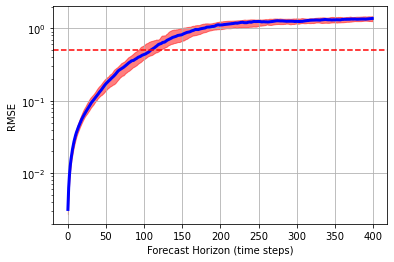

It takes around t = 1.09 for mean error to exceed 0.5


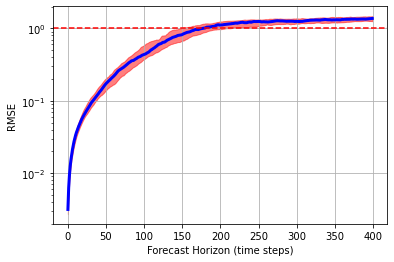

It takes around t = 1.77 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.061
Median NRMSE at t = 0.5: 0.173
Median NRMSE at t = 1: 0.438
Median NRMSE at t = 2: 1.115
Median NRMSE at t = 3: 1.252


In [18]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.1 spec_radius = 0.3

In [19]:
spec_radius = 0.3

In [20]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 20.40s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 4.06s
W and W_in generated. Time taken: 27.57s

Generating z values...
z values generated. Time taken: 46.96s
Concatenating z with z**2 Contenation complete. Time taken: 11.60s

Epoch 10: Train time = 10.62 | Train Loss = 0.0000147 
Epoch 20: Train time = 10.18 | Train Loss = 0.0000154 
Epoch 30: Train time = 9.85 | Train Loss = 0.0000138 
Epoch 40: Train time = 10.37 | Train Loss = 0.0000122 
Epoch 50: Train time = 10.42 | Train Loss = 0.0000110 
Epoch 51: Train time = 10.41 | Train Loss = 0.0000108 
Epoch 52: Train time = 10.45 | Train Loss = 0.0000108 
Epoch 53: Train time = 10.41 | Train Loss = 0.0000106 
Epoch 54: Train time = 10.46 | Train Loss = 0.0000104 
Epoch 55: Train time = 10.04 | Train Loss = 0.0000103 
Epoch 57: Train time = 10.49 | Train Loss = 0.0000102 
Epoch 58: Train time = 10.42 | Train Loss = 0.0000101 
Epoch 59: Train time = 10.47 | Train Loss = 0.0000100 
Epoch 60: Train ti

In [21]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 179.31


In [22]:
save_obj(mean_pred, "results/rc", "3_3_2_mu_preds.pkl")

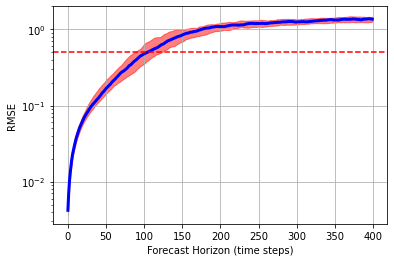

It takes around t = 1.05 for mean error to exceed 0.5


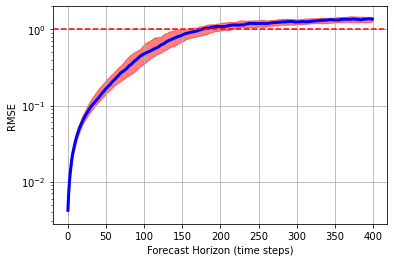

It takes around t = 1.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.065
Median NRMSE at t = 0.5: 0.168
Median NRMSE at t = 1: 0.478
Median NRMSE at t = 2: 1.090
Median NRMSE at t = 3: 1.248


In [23]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.3 spec_radius = 0.5
Already done in 3.2.3

### 3.3.4 spec_radius = 0.7

In [24]:
spec_radius = 0.7

In [25]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 20.92s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.00s
W and W_in generated. Time taken: 27.12s

Generating z values...
z values generated. Time taken: 47.68s
Concatenating z with z**2 Contenation complete. Time taken: 11.34s

Epoch 10: Train time = 10.66 | Train Loss = 0.0000709 
Epoch 20: Train time = 10.53 | Train Loss = 0.0000448 
Epoch 30: Train time = 10.49 | Train Loss = 0.0000287 
Epoch 40: Train time = 10.59 | Train Loss = 0.0000207 
Epoch 50: Train time = 10.58 | Train Loss = 0.0000160 
Epoch 51: Train time = 10.61 | Train Loss = 0.0000155 
Epoch 52: Train time = 10.64 | Train Loss = 0.0000154 
Epoch 53: Train time = 10.71 | Train Loss = 0.0000151 
Epoch 54: Train time = 10.67 | Train Loss = 0.0000146 
Epoch 55: Train time = 10.65 | Train Loss = 0.0000145 
Epoch 56: Train time = 10.71 | Train Loss = 0.0000141 
Epoch 57: Train time = 10.68 | Train Loss = 0.0000140 
Epoch 58: Train time = 10.61 | Train Loss = 0.0000136 
Epoch 59: Train t

In [26]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 224.05


In [27]:
save_obj(mean_pred, "results/rc", "3_3_4_mu_preds.pkl")

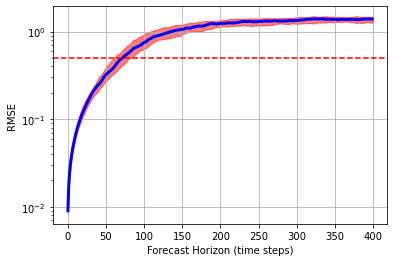

It takes around t = 0.72 for mean error to exceed 0.5


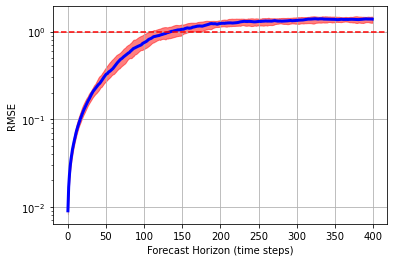

It takes around t = 1.36 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.122
Median NRMSE at t = 0.5: 0.325
Median NRMSE at t = 1: 0.747
Median NRMSE at t = 2: 1.234
Median NRMSE at t = 3: 1.338


In [28]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.4 connectivity

**Parameters**
- nn_size = 12000
- connectivity = [4, 8]
- spec_radius = ?
- lambda = 1e-6

In [29]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]
ridge_penalty = 1e-6
spec_radius = 0.1

### 3.4.1 connectivity = 4 
Already done in Section 3.3.1

### 3.4.2 connectivity = 8

In [30]:
connectivity = 8

In [31]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 18.16s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.44s
W and W_in generated. Time taken: 24.83s

Generating z values...
z values generated. Time taken: 51.43s
Concatenating z with z**2 Contenation complete. Time taken: 11.43s

Epoch 10: Train time = 11.06 | Train Loss = 0.0000120 
Epoch 20: Train time = 10.59 | Train Loss = 0.0000125 
Epoch 30: Train time = 10.62 | Train Loss = 0.0000117 
Epoch 40: Train time = 10.66 | Train Loss = 0.0000107 
Epoch 50: Train time = 10.62 | Train Loss = 0.0000099 
Epoch 51: Train time = 10.63 | Train Loss = 0.0000098 
Epoch 52: Train time = 10.62 | Train Loss = 0.0000098 
Epoch 53: Train time = 10.59 | Train Loss = 0.0000097 
Epoch 54: Train time = 10.69 | Train Loss = 0.0000095 
Epoch 56: Train time = 10.65 | Train Loss = 0.0000094 
Epoch 57: Train time = 10.64 | Train Loss = 0.0000094 
Epoch 58: Train time = 10.53 | Train Loss = 0.0000093 
Epoch 60: Train time = 10.54 | Train Loss = 0.0000091 
Epoch 61: Train t

In [32]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 194.21


In [33]:
save_obj(mean_pred, "results/rc", "3_4_2_mu_preds.pkl")

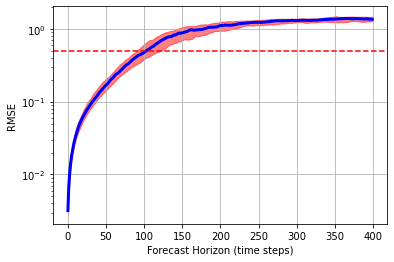

It takes around t = 1.04 for mean error to exceed 0.5


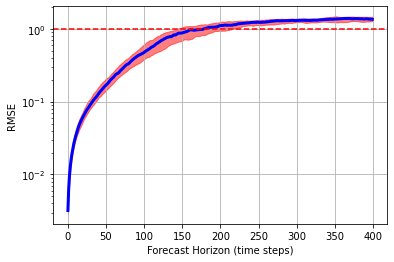

It takes around t = 1.79 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.063
Median NRMSE at t = 0.5: 0.169
Median NRMSE at t = 1: 0.475
Median NRMSE at t = 2: 1.110
Median NRMSE at t = 3: 1.301


In [34]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best model
nn_size = 12000  
beta = 1e-6  
connectivity = 4  
spec_radius = 0.1

In [11]:
nn_size = 12000
ridge_penalty = 1e-6
spec_radius = 0.1
connectivity = 4

lr_list = [1e-4]
epoch_list = [400]

transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

In [12]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 19.70s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 1.37s
W and W_in generated. Time taken: 24.19s

Generating z values...
z values generated. Time taken: 50.70s
Concatenating z with z**2 Contenation complete. Time taken: 11.38s

Epoch 10: Train time = 11.30 | Train Loss = 0.0000119 
Epoch 20: Train time = 10.54 | Train Loss = 0.0000125 
Epoch 30: Train time = 10.01 | Train Loss = 0.0000117 
Epoch 40: Train time = 10.49 | Train Loss = 0.0000107 
Epoch 50: Train time = 11.59 | Train Loss = 0.0000099 
Epoch 51: Train time = 11.97 | Train Loss = 0.0000098 
Epoch 52: Train time = 11.00 | Train Loss = 0.0000098 
Epoch 53: Train time = 10.75 | Train Loss = 0.0000097 
Epoch 54: Train time = 10.60 | Train Loss = 0.0000095 
Epoch 55: Train time = 11.23 | Train Loss = 0.0000094 
Epoch 57: Train time = 11.13 | Train Loss = 0.0000094 
Epoch 58: Train time = 10.95 | Train Loss = 0.0000093 
Epoch 59: Train time = 10.23 | Train Loss = 0.0000092 
Epoch 60: Train t

In [13]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 223.66


In [14]:
save_obj(mean_pred, "results/rc", "best_mu_preds.pkl")
save_obj(W, "results/rc", "best_W.pkl")
save_obj(W_in, "results/rc", "best_W_in.pkl")
save_obj(params, "results/rc", "best_params.pkl")

In [15]:
# W = load_obj("results/rc/best_W.pkl")
# W_in = load_obj("results/rc/best_W_in.pkl")
# params = load_obj("results/rc/best_params.pkl")

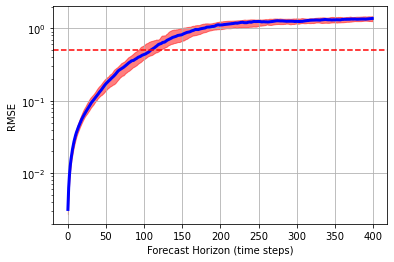

It takes around t = 1.09 for mean error to exceed 0.5


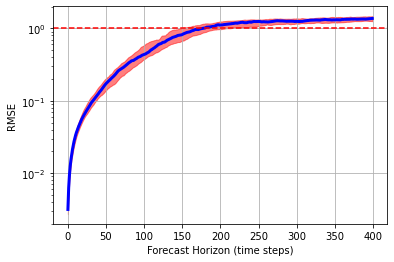

It takes around t = 1.77 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.061
Median NRMSE at t = 0.5: 0.173
Median NRMSE at t = 1: 0.438
Median NRMSE at t = 2: 1.115
Median NRMSE at t = 3: 1.252


In [16]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

**check disk space**

In [112]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

print(get_size("results/rc") / (2**30), 'GiB')

0.08522220607846975 GiB


In [113]:
import shutil

total, used, free = shutil.disk_usage("/")

print("Total: %d GiB" % (total // (2**30)))
print("Used: %d GiB" % (used // (2**30)))
print("Free: %d GiB" % (free // (2**30)))

Total: 192 GiB
Used: 173 GiB
Free: 9 GiB


# 5. Plot images based on Lyapunov Time

In [9]:
mean_pred = load_obj("results/rc/best_mu_preds.pkl")

In [10]:
# save_obj(mean_pred, "results", "rc_pred.pkl")

In [11]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

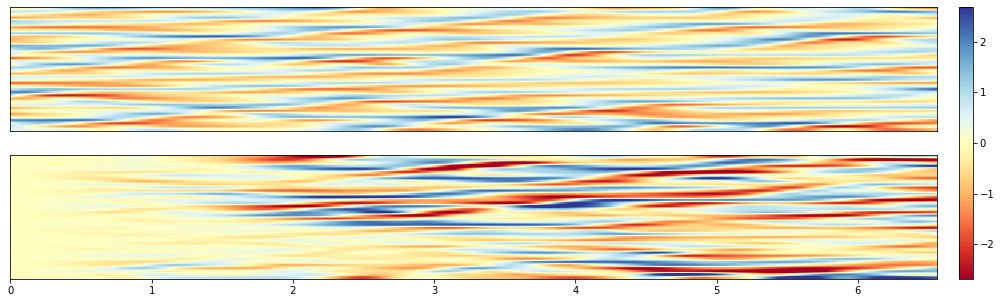

In [12]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_RC", pred_only = True)

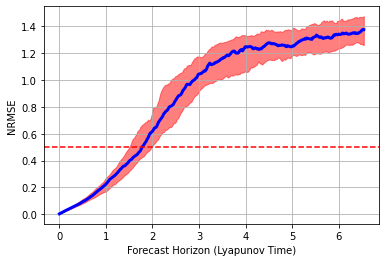

It takes around 1.79 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.091
Median NRMSE at 1.0 Lyapunov Time: 0.225
Median NRMSE at 2.0 Lyapunov Time: 0.618
Median NRMSE at 5.0 Lyapunov Time: 1.250


In [13]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "Figure3-6_RC_Prediction_Horizon")
print()
res_single.get_loss()